In [1]:
import cv2 
import numpy as np 
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
from PIL import Image
import random
import time

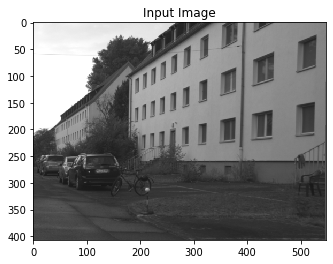

In [2]:
img = cv2.imread("road.png")
plt.imshow(img)
plt.title("Input Image")
plt.show()

In [3]:
def convolution(image, kernel):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
    output = np.zeros(image.shape)
    offset = int(math.floor(kernel_row)/2) 
    for row in range(image_row):
        for col in range(image_col):
            if(row < offset or col < offset or (row + offset > image_row - 1) or (col + offset > image_col - 1)):
                output[row][col] = image[row][col]
            else:
                for krow in range(kernel_row):
                    for kcol in range(kernel_col):
                        output[row][col] += kernel[krow][kcol] * image[row + krow - offset][col + kcol - offset]
    return output

In [4]:
def guassianFormula(x, y, sigma):
    result = (1/(2 * math.pi * sigma**2))
    result *= math.e**(-((x**2 + y**2)/(2*sigma**2)))
    return result

def GausianBlur(img, size, sigma):
    arr = np.array(img)
    gaus_kernel = np.zeros((size, size))
    center = int(math.floor(size/2))
    for i in range(size):
        for j in range(size):
            gaus_kernel[i][j] = guassianFormula(abs(center - i), abs(center - j), sigma)
    filt = convolution(arr, gaus_kernel)
    return filt

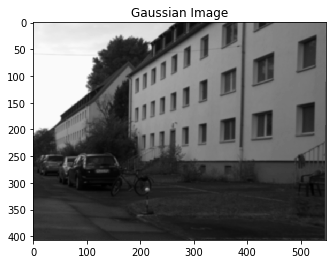

In [5]:
guas_img = GausianBlur(img, 5, 1)# image, kernel size, sigma
plt.imshow(guas_img, cmap='gray')
plt.title("Gaussian Image")
plt.show()

In [6]:
def sobelFilterVert(img):
    sobel_Vertical = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
    sobel_Vertical_img = convolution(img, sobel_Vertical)
    return sobel_Vertical_img
def sobelFilterHoriz(img):
    sobel_Horizontal = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])
    sobel_Horizontal_img = convolution(img, sobel_Horizontal)
    return sobel_Horizontal_img

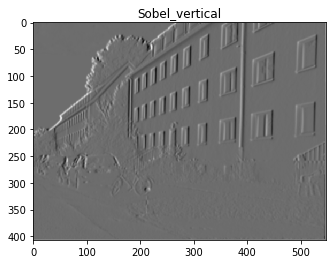

In [7]:
Sobel_vertical = sobelFilterVert(guas_img)
plt.imshow(Sobel_vertical, cmap='gray')
plt.title("Sobel_vertical")
plt.show()

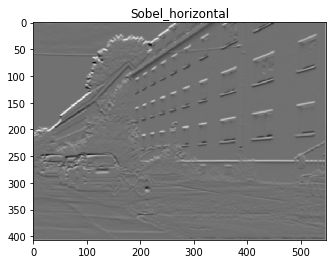

In [8]:
Sobel_horizontal = sobelFilterHoriz(guas_img)
plt.imshow(Sobel_horizontal, cmap='gray')
plt.title("Sobel_horizontal")
plt.show()

In [9]:
def nonMaxSupp(img):
    result = img
    img_row, img_col = img.shape
    for row in range(1, img_row - 1):
        for col in range(1, img_col - 1):
            if img[row][col] != max(img[row-1][col-1], img[row-1][col], img[row-1][col+1],img[row][col-1], img[row][col], img[row][col+1],img[row+1][col-1], img[row+1][col], img[row+1][col+1]):
                result[row][col] = 0
            else:
                for h1 in range(0, 3):
                    for h2 in range(0, 3):
                        if not (h1 == 1 and h2 == 1):
                            result[row + h1 -1][[col + h2 -1]] = 0
    return result


In [10]:
def getHessian(img):

    image_row, image_col = img.shape
    ouput = np.zeros((image_row, img.shape[1]))
    
    img_xx = sobelFilterHoriz(sobelFilterHoriz(img))
    img_yy = sobelFilterVert(sobelFilterVert(img))
    img_xy = sobelFilterHoriz(sobelFilterVert(img))
    theta = np.arctan2(img_yy, img_xx)

    det = np.zeros((image_row, image_col))
    for row in range(image_row):
        for col in range(image_col):
            det[row][col] = img_xx[row][col]*img_yy[row][col] - img_xy[row][col]**2
    
    det_row, det_col = det.shape
# Get max and min values to use for thresholding
    maxium = np.amax(det)
    minimum = np.amin(det)
    diff_val = maxium - minimum

    for row in range(det_row):
        for col in range(det_col):
            det[row][col] = (det[row][col] - minimum) * (255/diff_val)
# Threshold = 150
#if value less than 150 then assign 0
    for row in range(det_row):
        for col in range(det_col):
            if det[row][col] < 150:
                det[row][col] = 0
            else:
                det[row][col] = 255
    print(det)
    suppressed = nonMaxSupp(det)
    return suppressed



In [11]:
plotted_points = getHessian(guas_img)
suppress_img = cv2.imwrite("Hessian.jpg", plotted_points.copy())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
def Points(img, threshold):
    points = []
    img_row, img_col = img.shape
# Loop through all pixels in image and get all coordinates of pixels with value above threshold
    for row in range(img_row):
        for col in range(img_col):
            if img[row][col] > threshold:
                points.append((col, row))
    return points

In [13]:
def RandomPoints(ptList):
    pt1 = random.randint(0, len(ptList) - 1)

    pt2 = random.randint(0, len(ptList) - 1)

    while(pt2 == pt1):
        pt2 = random.randint(0, len(ptList) - 1)
    pt1_temp = ptList[pt1]
    pt2_temp = ptList[pt2]

    return pt1_temp, pt2_temp

In [14]:
def RANSAC(img, normal_img, num_of_lines, num_points):
    img_row, img_col = img.shape
    points = Points(img, 0)
    lines = 0
    row_dist = 3

    while(lines < num_of_lines):
# Get two random points
        point1, point2 = RandomPoints(points)
        x1,y1 = point1[0],point1[1]
        x2,y2 = point2[0],point2[1]
#line equation y=mx+c
        if(x1 == x2):
            m = math.inf #slope is infinity(not define) if its vertical
        else:
            m = (y2 - y1)/(x2 - x1) 
            c = -m*x1 + y1
        inliers = []
        max_line_size = 0

        for point in points:
            line_x = (point[0] + (m*point[1]) - (m*c))/(1 + m**2)
            line_y = ((m*point[0]) + ((m**2)*point[1]) - ((m**2)*c))/(1 + m**2) + c
            dist = math.sqrt(((line_x - point[0])**2) + ((line_y - point[1])**2))

# if the point is close enough to the line then add to inliers
            if dist < row_dist:
                inliers.append((point[0], point[1]))

# if the number of inliers for the line is above minimal amount required then add line count
        if(len(inliers) > num_points):
            lines += 1

# Remove the inliers that were already considered
            for point in inliers:
                points.remove((point[0], point[1]))

# Plot the inliers as 3x3 squares
                for i in range(0, 3):
                    for j in range(0, 3):
# Check if the pixel is out of bounds
                        if ((point[0] + i - 1) > img_row) or ((point[1] + j - 1) > img_col):
                            continue
                        else:
                            img[point[1] + j - 1][point[0] + i - 1] = 255

# Loop through the rest of the points to find the two points with Largest distance b/w them
                for second_pt in inliers:
                    point_dist = math.sqrt(((point[0] - second_pt[0])**2) + ((point[1] - second_pt[1])**2))
                    if point_dist > max_line_size:
                        max_line_size = point_dist
# Holding the two points that make the largest line for a set of inliers
                        most_dist_points = ((point[0], point[1]), (second_pt[0], second_pt[1]))

# Plot the line from one most distant inlier to the other on the image with points
            cv2.line(img, most_dist_points[0], most_dist_points[1], (255, 255, 255), thickness=1)

# Plot the line from one most distant inlier to the other on the normal image
            cv2.line(normal_img, most_dist_points[0], most_dist_points[1], (0, 0, 0), thickness=2)

        if lines == num_of_lines:
            cv2.imwrite("RANSACpointimage1.jpg", img)
            cv2.imwrite("RANSACNormalimage1.jpg", normal_img)




In [15]:
RANSAC(plotted_points.copy(), img.copy(), 4, 40)

In [16]:
def HoughTran(img, normal_img, number_of_lines):
    img_row, img_col = img.shape
    largest_value = 0
    minimum = -img_col
    offset = -minimum
    maximum = img_row + img_col
    diff_val = maximum - minimum
    Bin_space = np.zeros((diff_val, 181))
    lines = 0
# Getting the feature points from the image
    points = Points(img, 0)
# Loop through all the points and angles
    for point in points:
        x,y = point[0],point[1]
        for angle in range(0, 181):
            rads = math.radians(angle)
            rho = int(x*math.cos(rads) + y*math.sin(rads) + offset)
            Bin_space[rho][angle] += 1
    
    nonMax = nonMaxSupp(Bin_space)
    while lines < number_of_lines:
# Finding the max value in the hough transform which should correclate to the parameters of the strongest line
        for i in range(nonMax.shape[0]):
            for j in range(nonMax.shape[1]):
                if nonMax[i][j] > largest_value:
                    maxparams = (j, i)
                    largest_value = nonMax[i][j]
        largest_value = 0
# Set the pixels around the chosen model equal to 0
        for i in range(-10, 10):
            for j in range(-10, 10):
                nonMax[maxparams[1] + i][maxparams[0] + j] = 0
# updating theta and rho with max params values
        theta = math.radians(maxparams[0])
        rho = maxparams[1]-offset 
        q,r = math.cos(theta), math.sin(theta)
        x,y = q*rho, r*rho
        pt1 = (int(x+1000*(-r)), int(y+1000*(q)))
        pt2 = (int(x-1000*(-r)), int(y-1000*(q)))
        cv2.line(img, pt1, pt2, (255, 255, 255), thickness=1)
        cv2.line(normal_img, pt1, pt2, (0, 0, 0), thickness=2)
        lines += 1

    cv2.imwrite("Hough.jpg",img)
    cv2.imwrite("HoughLinesImage.jpg",normal_img)

In [17]:
HoughTran(plotted_points.copy(), img.copy(), 4)